# This script is for Vehicle Detection and Tracking Project

In [1]:
#import necessary libraries and functions

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

## Step 1: Histogram of Oriented Gradient

In [2]:
# Read in our vehicles and non-vehicles from provided image files
cars = glob.glob('vehicles/vehicles/KITTI_extracted/*.png')
notcars= glob.glob('non-vehicles/non-vehicles/Extras/*.png')

shuffle(cars)
shuffle(notcars)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist(), and get_hog_features()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### These are parameters that can be changed to obtain better accuracy
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 6
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(64, 64)
hist_bins=32

#perform feature extract
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features')

45.7 Seconds to extract HOG features


## Step 2: Spatial Bins and Color Histograms

In [29]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features2(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    feats=[]
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Apply bin_spatial() to get spatial color features
        bs = bin_spatial(feature_image, spatial_size)
        # Apply color_hist() to get color histogram features
        ch = color_hist(feature_image, hist_bins)
        # Append the new feature vector to the features list
        #features.append(np.concatenate((bs, ch)))
        features.append(bs)
        feats.append(ch)
        #X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
    # Return list of feature vectors
    return features, feats

colorspace2='HLS'
secondary_cars, sc = extract_features2(cars, cspace=colorspace2, spatial_size=spatial_size, hist_bins=hist_bins,
                                     hist_range=(0,256))
secondary_notcars, sn = extract_features2(notcars, cspace=colorspace2, spatial_size=spatial_size, hist_bins=hist_bins,
                                     hist_range=(0,256))

#test=np.hstack((secondary_cars,car_features))
car_allfeatures=np.hstack((secondary_cars,sc,car_features))
notcar_allfeatures=np.hstack((secondary_notcars,sn,notcar_features)) 

# Create an array stack of feature vectors
X = np.vstack((car_allfeatures, notcar_allfeatures)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X to normalize the features
scaled_X = X_scaler.transform(X)

# Define the labels vector of 1's for car and 0's for not car
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('done')

done


## Step 3: Train Linear SVM Classifier

In [30]:
# Split up data into randomized training and test sets (80% train, 20% testing data)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#fit the classifier to the data
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 10 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 22104
78.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9991
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
0.03209 Seconds to predict 10 labels with SVC


In [42]:
# save the classifier
with open('svm_classifier.pkl', 'wb') as fid:
    pickle.dump(svc, fid)    

In [ ]:
# load it again
with open('scm_classifier.pkl', 'rb') as fid:
    svc = cPickle.load(fid)

## Step 4: Implement Sliding Window Search Technique

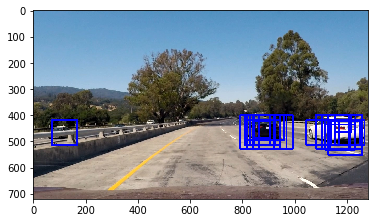

In [49]:
#import a test image
img = mpimg.imread('test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale_vec, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

        
    bbox=[]
    
    for scale in scale_vec:
        
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        ctrans_secondary =cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS) #img_tosearch 

        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            ctrans_secondary= cv2.resize(ctrans_secondary, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                subimg_secondary = cv2.resize(ctrans_secondary[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = bin_spatial(subimg_secondary, size=spatial_size)
                hist_features = color_hist(subimg_secondary, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    x1=xbox_left
                    y1=ytop_draw+ystart
                    x2=xbox_left+win_draw
                    y2=ytop_draw+win_draw+ystart
                    bbox.append([(x1,y1),(x2,y2)])

        for box in bbox:
            cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
                
    return draw_img, bbox



ystart = 400
ystop = 656
scale = [1,1.5,2]
    
out_img, bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,spatial_size, hist_bins)

#for box in bbox:
#    cv2.rectangle(out_img,box[0],box[1],(0,0,255),6)

plt.imshow(out_img)

## Step 5: Apply Heat Map to Find Bounding Boxes

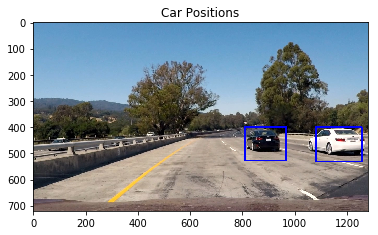

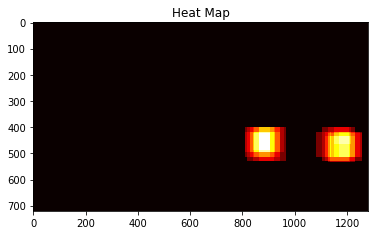

In [51]:
# Read in image similar to one shown above 
#same image as above 'img'
heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,bbox)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
#plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
fig = plt.figure()
#plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
#fig.tight_layout()


## Step 6: Implement Video Process with Pipeline Above

In [33]:
#import video editing and displaying libraries
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
# declare global variables needed frame to frame
heatmaps = []
heatmap_sum = np.zeros((720,1280)).astype(np.float64)

In [44]:


#import pipeline into a function
def process_image(image):
    
    #i don't need to retrain or anything
    #start with sliding window
    out_img, bbox = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient,
                              pix_per_cell, cell_per_block,spatial_size, hist_bins)
    #heat map
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,bbox)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    #labels = label(heatmap)
    #final_image = draw_labeled_bboxes(np.copy(image), labels)
    
    global heatmaps
    global heatmap_sum
    
    # subtract off old heat map to keep running sum of last n heatmaps
    if len(heatmaps)>5:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum,0.0,1000000.0)
    
    
    heatmap_sum = heatmap_sum + heatmap
    heatmaps.append(heat)
    
    labels = label(heatmap_sum/len(heatmaps))
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    
    
    #send result    
    return final_image

In [45]:
output_vid = 'p5video.mp4'
clip1 = VideoFileClip("project_video.mp4")
p5clip = clip1.fl_image(process_image)
#%time p4clip.write_videofile(output_vid, audio=False)
%time p5clip.write_videofile(output_vid, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video p5video.mp4
[MoviePy] Writing video p5video.mp4



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:09<00:02,  2.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p5video.mp4 

Wall time: 47min 10s


In [46]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output_vid))